In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import matplotlib.animation as animation
from tqdm.notebook import tqdm

%matplotlib notebook

In [2]:
#CONSTANTS

h = 1.0546e-27
c = 2.9979e10
kb = 1.3807e-16
mp = 1.6726e-24
me = 9.1094e-28
e = 4.8032e-10

In [218]:
class Ocean:
    def __init__(self,ny,ylow, yhigh, A = 56,Z = 26):
        
        self.ny = ny
        self.y_edges = np.linspace(ylow,yhigh,ny+1)
        self.y = self.y_edges[:-1]
        self.dy = np.diff(self.y_edges)
        self.T = np.zeros(ny)
        self.F = np.zeros((ny,2))
        self.ne = np.ones(ny)*1e30
        self.cp = np.zeros(ny)
        self.k = np.zeros(ny)
        self.rho = np.zeros(ny)
        self.P = np.zeros(ny)
        self.T_evol = np.zeros(ny)
        self.t = np.zeros(1)
        
        self.A = A
        self.Z = Z
        
    def set_IC_linear(self):
        self.T = -self.y+self.y[-1]
        
    def set_IC_exp(self):
        self.T = np.exp(-(self.y-self.y[0])/(0.1*np.ptp(self.y)))*2e8

    def set_IC_step(self):
        self.T = np.ones(len(self.T))
        self.T[:len(self.T)//2] = 2
        
    def set_IC_random(self):
        self.T = np.random.uniform(0,10,len(self.T))
    
    def set_IC_flat(self,T0):
        
        self.T = np.array(len(self.T)*[T0,])
        
    def compute_k(self):
        
        Ef = h*c*(3*np.pi**2*self.ne)**(1/3)
        me_eff = me+Ef/c**2
        
        nu = 4*e**4*me_eff/(3*np.pi*h**3)*self.Z
        self.k = np.pi**2/3*self.ne*kb**2*self.T/(me_eff*nu)
        
    def compute_P(self):
        
        Ef = h*c*(3*np.pi**2*self.ne)**(1/3)
        self.P = 1/4*self.ne*Ef
        
    def compute_rho(self):
        self.rho = self.ne/self.Z*self.A*mp
        
    def compute_cp(self):
        
        self.cp = np.ones(len(self.cp))*(3*kb)/(self.A*mp)
        
    def compute_flux(self, rad_flux = 1e6):
        
        self.compute_k()
        
        dTdy = (self.T[1:]-self.T[:-1])/self.dy[1:]
        k_mid = 0.5*(self.k[1:]+self.k[:-1])
        
        F_bot = np.zeros(len(self.y))
        F_top = np.zeros(len(self.y))
        
        F_top[1:] =  k_mid*dTdy
        F_bot[:-1] = -k_mid*dTdy
        
        F_bot[-1] = 0
        F_top[0] = rad_flux
        
        self.F[:,1] = F_bot
        self.F[:,0] = F_top
        
    def time_evolve(self,t_tot):
                
        T = self.T
        self.T_evol = T
        
        def diffusion_system(t,T,pbar,state):
            
            self.T = T
            self.compute_P()
            self.compute_rho()
            self.compute_cp()
            self.compute_flux()
            
            last_t, dt = state
            n = int((t - last_t)/dt)
            pbar.update(n)
            state[0] = last_t + dt * n
            
            dT = np.zeros(len(T))
            
            for i in range(len(T)):
                dT[i] = (self.cp[i])**-1*(-self.F[i,0]-self.F[i,1])/self.dy[i]
#             print(dT)
            return dT       
            
            
        with tqdm(total = 1000) as pbar:
            sol = solve_ivp(diffusion_system,(0,t_tot),self.T, method = 'RK45'
                           , args=[pbar, [0,t_tot/1000]])
            
        self.T = sol.y.T[-1]
        self.T_evol = np.vstack((self.T_evol,sol.y.T))
        self.t = np.hstack((self.t,sol.t))

    def plot_light_curve(self):
        
        fig, ax = plt.subplots()
        ax.plot(self.t,kb*np.array(self.T_evol)[:,0])
        ax.set_xlabel('$t$')
        ax.set_ylabel('$k_bT$')
    
    def plot_T(self):
        
        fig,ax = plt.subplots()
        
        ax.semilogx(self.y,self.T)
        ax.set_xlabel('$y$')
        ax.set_ylabel('$T$')
        fig.show()
        
    def plot_T_history(self,n_curves):
        
        fig,ax = plt.subplots()
        ax.set_xlabel('$y$')
        ax.set_ylabel('T')
        ax.plot(self.T_evol[0], linestyle = '--', label = '$t=0$')
        for i in range(1,n_curves+1):
            idx = i*(len(self.T_evol)//n_curves)-1
            ax.plot(self.T_evol[idx], label = '$t = {}$'.format(round(self.t[idx],1)))
        fig.legend()
            
        
        
    def animate_T(self,fname, save = False):    
        fig, ax = plt.subplots()
        ax.set_xlim(0,self.ny)
        ax.set_ylim(np.min(self.T_evol),np.max(self.T_evol))
        ax.set_xlabel('$y$')
        ax.set_ylabel('T')
        line, = ax.plot([], [])
        
        def init():
            line.set_data([],[])
            return line,

        def animate(frame):
            y = self.T_evol[frame]
            line.set_data((self.y,self.T_evol[frame]))
            return line,

        anim = animation.FuncAnimation(fig,animate,frames = np.linspace(0,len(self.T_evol),1000,dtype = int), interval = 2, init_func = init,blit = 1)
        writergif = animation.PillowWriter(fps=30)
        if save:
            anim.save('D:/Mcgill/F2023/Ns cooling animations/{}.gif'.format(fname), writer=writergif)

<IPython.core.display.Javascript object>


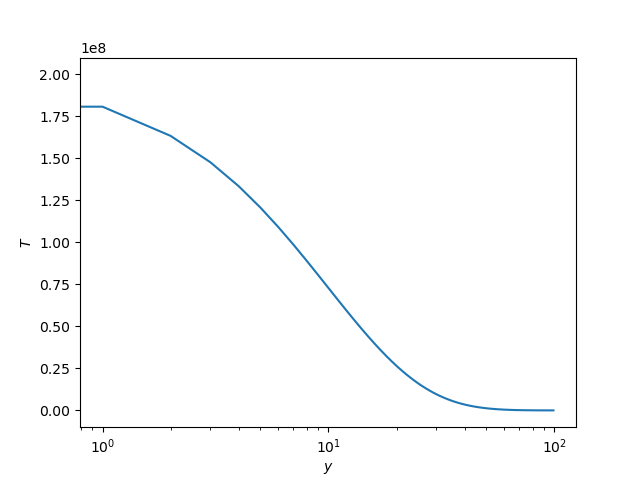

In [219]:
ocean = Ocean(int(1e2),0,100,56,26)
ocean.set_IC_exp()
ocean.plot_T()
ocean.compute_flux()


In [220]:
ocean.time_evolve(1)

KeyboardInterrupt: 

In [ ]:
ocean.plot_T_history(3)